# Business Understanding
Disaster response systems are playing and will play an even more crucial role in the future in the context of weather extremes related to global warming. During a disaster, millions of messages are sent through multi-channels and there is a great need for system helping to categorize and prioritize victim messages to alert proper support organizations to provide effective and efficient help. Such a system can save a lot of lives.

## Performance Metrics
It is equally important to correctly identify 
 - the true danger to human life to safe lives -> maximize recall (TP/(TP+FN)
 - the false danger to human life to safe limited resources which are usually missing in a real disaster situation -> maximize precision (TP/(TP+FP)
 
For these reasons, the __f1 score__ harmonic mean of precision and recall will be used to evaluate such a system performance.

As I am interested more about the discriminating performance of the model between 36 message labels over putting weight on correctly classifying more frequent categories the __macro average f1 score__ will be used for __multi-label classification__.

In [1]:
# IMPORTS

# Core libraries
import time
import warnings
from functools import partial
from itertools import combinations
import pickle
import re
import ipdb

# Databases
from sqlalchemy import create_engine

# Numerical computation and statistics
import dython.nominal as dt
from dython._private import convert
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels as sm
from statsmodels.discrete.discrete_model import MNLogit

# Oversampling to cope with imbalanced datasets
from imblearn.over_sampling import SMOTENC

# Natural language processing
import nltk
nltk.download(['punkt', 
               'wordnet', 
               'stopwords', 
               'averaged_perceptron_tagger',
               'omw'])
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# Utils
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# Feature selection
from sklearn.feature_selection import SelectFromModel

# Estimators
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.dummy import DummyClassifier

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Multi-label classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


## 2. Data Understanding
There are 26215 disaster messages categorized to 36 categories where the `child-alone` category never realized in the training sample. Even if it does not add any useful information in training the model, it will not be deleted as future training set updates can contain such an important category.

In [2]:
# load data from database
engine = create_engine('sqlite:///..//data//disaster_response.db')
df = pd.read_sql_table('train_data', con=engine)
display(df.head(n=1))
display(df.info())

X = df[['message', 'genre']]
display(X.head())

categories = df.columns.drop(['id', 'message', 'original', 'genre'])
Y = df[categories]
display(Y.head())

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26215 entries, 0 to 26214
Data columns (total 40 columns):
id                        26215 non-null int64
message                   26215 non-null object
original                  10170 non-null object
genre                     26215 non-null object
related                   26215 non-null int64
request                   26215 non-null int64
offer                     26215 non-null int64
aid_related               26215 non-null int64
medical_help              26215 non-null int64
medical_products          26215 non-null int64
search_and_rescue         26215 non-null int64
security                  26215 non-null int64
military                  26215 non-null int64
child_alone               26215 non-null int64
water                     26215 non-null int64
food                      26215 non-null int64
shelter                   26215 non-null int64
clothing                  26215 non-null int64
money                     26215 non-null i

None

,message,genre
0,Weather update - a cold front from Cuba that c...,direct
1,Is the Hurricane over or is it not over,direct
2,Looking for someone but no name,direct
3,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,"says: west side of Haiti, rest of the country ...",direct


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Check the constant categories
Y_constant = (Y.apply(lambda column: len(column.unique()) == 1)
               .rename('constant_category'))

constant_category_list = Y_constant.index[Y_constant].to_list()
# Y = Y.drop(columns=constant_category_list, errors='ignore')
constant_category_list

['child_alone']

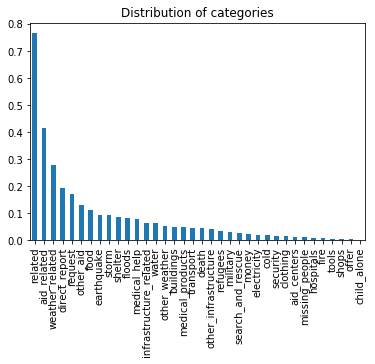

In [4]:
# Check if categories are balanced
((Y.sum(axis=0) / Y.index.size)
 .sort_values(ascending=False)
 .plot.bar(title='Distribution of categories'));

### 2.2. Feature Engineering and Selection
#### 2.2.1. Hypothesis
The `genre`, `message_length`, and `starting_verb` features are considered to improve model performance. The following hypothesis needs to be confirmed:
 - `genre` might be correlated with categories as `direct` can relate to action-oriented categories like `aid_related`, `search_and_rescue` etc. oppose to `news` where relation might be informational like `floods`, `earthquake`, `other_weather` etc.
 - `text_length` can be shorter for action-oriented categories and longer for informational categories
 - `startging_verb` messages may indicate action categories as opposed to informational ones

#### 2.2.2. Multinomial Logistic Regression
__Multinomial Logistic Regression__ is used to determine the relationship between continuous (`message_length`), categorical (`genre`, `starting-verb`) features and categorical dependent variable (`category`)

#### Normality Prerequisite
`text_length` distribution is  highly skewed. It is tranformed and scaled to `text_length_pwr_std`.

#### Multi-collinearity Prerequisite
The categorical variable `genre` is one-hot-encoded to two binary variables `news` and `social` where `direct` is dropped to prevent multicollinearity.

`news` genre is collinear with `text_length_pwr_std` and `social` genre. It is dropped from input features 

In [5]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    '''Custom transformer extracting length of the text'''
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        try:
            X_len = X.str.len()
        except:
            raise ValueError('X is: ', X)
        return X_len.values.reshape(-1, 1)
    
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    '''Custom transformer flagging text starting by verb
    
    Attributes: 
        tokenizer: Callable, custom word tokenizer function,
            If None nltk.tokenize.word_tokenizer by default
    
    '''
    
    def __init__(self, tokenizer=word_tokenize):
        super(BaseEstimator).__init__()
        super(TransformerMixin).__init__()
        self.tokenizer = tokenizer

    def _start_with_verb(self, text):
        '''Boolean flag of text starting with verb'''
        sentence_list = sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = pos_tag(self.tokenizer(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP']:
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        '''Transforms text feature to boolean feature indicating
        whether text starts with verb.
        
        Args:
            X: Array-like of text samples of size (# samples)
        
        Returns:
            X_tagged: Dataframe of with verb indicator of shape (# samples, 1)
        '''
        X_tagged = pd.Series(X).apply(self._start_with_verb)
        return pd.DataFrame(X_tagged)
    
def build_feature_extractor():
    '''Returns transformer to engineer features from messages'''
    
    feature_extractor = ColumnTransformer([
        
        # Build text features parallely
        ('text_features', FeatureUnion([
            # Extract and Scale text length 
            ('text_length', Pipeline([
                ('extractor', TextLengthExtractor()),
                ('power_transformer', PowerTransformer()),
                ('scaler', StandardScaler())
            ])),
            # Extract starting verb feature
            ('starting_verb', StartingVerbExtractor())
        ], n_jobs=-1), 'message'),
        
        # one hot encode genre and drop one level to prevent multicolinarity
        ('onehot_encodings', OneHotEncoder(drop='first'), ['genre'])
    ], n_jobs=-1)
    
    return feature_extractor

def stack_categories(df, **melt_kws):
    '''Stacked categories in columns to one category column'''
    
    stacked_df = pd.melt(df, **melt_kws)

    # keep only valid categories (number 1 in indicator matrix)
    if 'value_name' in melt_kws:
        is_valid_category = melt_kws['value_name']
    else:
        is_valid_category = 'value'
        
    stacked_df = stacked_df[stacked_df[is_valid_category] == 1]
    
    # remove category binary indicator
    stacked_df.drop(columns=[is_valid_category], inplace=True)
    
    return stacked_df

def corr_matrix(dataset, nominal_columns=None, mark_columns=False, 
               theil_u=False, plot=True, return_result = False, **kwargs):
        """
        Calculate the correlation/strength-of-association of features in 
        data-set with both categorical (eda_tools) and continuous features using:
         * Pearson's R for continuous-continuous cases
         * Correlation Ratio for categorical-continuous cases
         * Cramer's V or Theil's U for categorical-categorical cases

        **Example:** see `associations_example` under `dython.examples`

        Args:
            dataset : NumPy ndarray / Pandas DataFrame
                The data-set for which the features' correlation is computed
            nominal_columns : string / list / NumPy ndarray
                Names of columns of the data-set which hold categorical values. 
                Can also be the string 'all' to state that all columns are 
                categorical, or None (default) to state none are categorical
            mark_columns : Boolean, default = False
                if True, output's columns' names will have a suffix of '(nom)' 
                or '(con)' based on there type (eda_tools or continuous), 
                as provided by nominal_columns
            theil_u : Boolean, default = False
                In the case of categorical-categorical feaures, use Theil's U 
                instead of Cramer's V
            plot : Boolean, default = True
                If True, plot a heat-map of the correlation matrix
            return_result : Boolean, default = False
                If True, the function will return a Pandas DataFrame of the 
                computed associations
            kwargs : any key-value pairs
                Arguments to be passed to used function and methods
                
        Returns: 
            corr: a DataFrame of the correlation/strength-of-association 
                between all features
        """
        dataset = convert(dataset, 'dataframe')
        columns = dataset.columns
        if nominal_columns is None:
            nominal_columns = list()
        elif (isinstance(nominal_columns, str) 
              and nominal_columns == 'all'):
            nominal_columns = columns
        corr = pd.DataFrame(index=columns, columns=columns)
        for i in range(0,len(columns)):
            for j in range(i,len(columns)):
                if i == j:
                    corr[columns[i]][columns[j]] = 1.0
                else:
                    datapair = dataset[[columns[i], columns[j]]].dropna()
                    if columns[i] in nominal_columns:
                        if columns[j] in nominal_columns:
                            if theil_u:
                                corr[columns[j]][columns[i]] = (
                                    dt.theils_u(datapair[columns[i]]
                                                ,datapair[columns[j]])
                                )
                                corr[columns[i]][columns[j]] = (
                                    dt.theils_u(datapair[columns[j]],
                                                datapair[columns[i]])
                                )
                            else:
                                cell = dt.cramers_v(datapair[columns[i]],
                                                    datapair[columns[j]])
                                corr[columns[i]][columns[j]] = cell
                                corr[columns[j]][columns[i]] = cell
                        else:
                            cell = dt.correlation_ratio(datapair[columns[i]], 
                                                        datapair[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        if columns[j] in nominal_columns:
                            cell = dt.correlation_ratio(datapair[columns[j]], 
                                                        datapair[columns[i]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                        else:
                            cell, _ = stats.pearsonr(datapair[columns[i]], 
                                                     datapair[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
        
        corr.fillna(value=np.nan, inplace=True)
        if mark_columns:
            marked_columns = ['{} (nom)'.format(col) if col in nominal_columns 
                              else '{} (con)'.format(col) for col in columns]
            corr.columns = marked_columns
            corr.index = marked_columns
        if plot:
            plt.figure(figsize=kwargs.get('figsize',None))
            sns.heatmap(corr, 
                        annot=kwargs.get('annot', None), 
                        fmt=kwargs.get('fmt','.2f'), 
                        cmap=kwargs.get('cmap', 'RdYlBu'), 
                        vmin=kwargs.get('vmin', -1),
                        vmax=kwargs.get('vmax', 1), 
                        square=kwargs.get('square', True))
            plt.title(label=kwargs.get('label', 'Assosciation Matrix'))
            plt.show()
        if return_result:
            return corr
        
def mn_logit_test(input_, output, normalize=False, **kws):
    '''Fit Multinomial logistic regression model.
    
    Args:
        input_: Array like, input variables of
            shape (# samples, # variables)
        output_: Array like, categorical output variable of
            size # samples
        normalize: Boolean, normalize inputs, by default True
        kws: Keyword arguments to MNlogit function.
            
    Returns: 
        model: Fitted statsmodels.discrete.discrete_model.MNLogit
            object.
    '''
    input_, output = np.asarray(input_), np.asarray(output)
    
    if normalize:
        input_ = (input_ - input_.mean(axis=0)) / input_.std(axis=0)
    
    # add constant to exog array for intercept
    input_ = sm.tools.tools.add_constant(
        input_, prepend=False, has_constant='raise'
    )
    logit = MNLogit(output, input_, **kws)
    model = logit.fit()
    
    return model

def engineer_features(X, Y):
    '''Engineer features and returns input and output transformed
       to multi-classification problem.
       
    Args:
        X: Dataframe of input features of shape (# samples, # features)
        y: Datafraem of multi-label output of shape (# samples, # labels).
            Each label is binary variable.
    
    Returns:
        X_eng: Dataframe of engineered features 'message_length_std_pwr',
            'starting_verb', 'news' and 'social' of shape (# samples 
            corresponding to stacked # of valid labels, # engineered features)
        y: Series of output variable 'label' with size of (# samples
            corresponding to stacked # of valid labels)
    '''
    df = pd.concat([X, Y], axis=1)
    
    # Stack categories columns to one category column
    stacked_df = stack_categories(df,
                                  id_vars=X.columns,
                                  value_vars=Y.columns,
                                  var_name='category',
                                  value_name='category_flag')

    # Engineer features 
    X = stacked_df[['message', 'genre']]
    y = stacked_df['category']

    feature_extractor = build_feature_extractor()
    X_eng = feature_extractor.fit_transform(X)

    # Reconstruct engineered features dataframe
    genre_category_idx = pd.Index((feature_extractor
                                   .named_transformers_['onehot_encodings']
                                   .categories_)[0])

    droped_genre_category_idx = genre_category_idx[
        (feature_extractor
        .named_transformers_['onehot_encodings']
        .drop_idx_)[0]
    ]

    one_hot_feature_idx = genre_category_idx.drop(droped_genre_category_idx)
    engineered_feature_list = ['text_length_pwr_std', 'starting_verb']
    engineered_feature_list.extend(one_hot_feature_idx)

    X_eng = pd.DataFrame(X_eng, index=X.index, columns=engineered_feature_list)
    
    return X_eng, y

In [6]:
# %%time
# Evaluate if engineered features can be good predictors of categories
# --------------------------------------------------------------------

# Engineer features
X_eng, y = engineer_features(X, Y)
display(X_eng)
display(y.value_counts(normalize=True))

,text_length_pwr_std,starting_verb,news,social
0,-1.168404,0.0,0.0,0.0
1,-2.224727,0.0,0.0,0.0
2,-2.725661,0.0,0.0,0.0
3,-0.420025,0.0,0.0,0.0
4,-1.256800,0.0,0.0,0.0
...,...,...,...,...
943655,-0.141813,0.0,1.0,0.0
943705,-0.258477,0.0,1.0,0.0
943721,1.706199,0.0,1.0,0.0
943722,0.015942,0.0,1.0,0.0


related                   0.241694
aid_related               0.130632
weather_related           0.087774
direct_report             0.061046
request                   0.053817
other_aid                 0.041451
food                      0.035160
earthquake                0.029531
storm                     0.029386
shelter                   0.027835
floods                    0.025922
medical_help              0.025068
infrastructure_related    0.020509
water                     0.020112
other_weather             0.016552
buildings                 0.016034
medical_products          0.015794
transport                 0.014447
death                     0.014362
other_infrastructure      0.013845
refugees                  0.010525
military                  0.010345
search_and_rescue         0.008709
money                     0.007265
electricity               0.006399
cold                      0.006375
security                  0.005666
clothing                  0.004872
aid_centers         

In [7]:
# Apply Synthetic Minority Oversampling for nominal and continuous features
# This is to cope with unbalanced classes in order to solve convergence of 
# Multi-nomial Logistic Regression and improve classification performance
random_state=1
categorical_feature_msk = ~(X_eng.columns.str.contains('length'))

smote_nc = SMOTENC(categorical_features=categorical_feature_msk,
                   sampling_strategy='not majority',
                   random_state=random_state,
                   n_jobs=-1)

X_eng_resampled, y_resampled = smote_nc.fit_resample(X_eng, y)
display(y_resampled.value_counts(normalize=True))

refugees                  0.028571
weather_related           0.028571
storm                     0.028571
earthquake                0.028571
offer                     0.028571
cold                      0.028571
aid_related               0.028571
search_and_rescue         0.028571
security                  0.028571
request                   0.028571
direct_report             0.028571
related                   0.028571
military                  0.028571
clothing                  0.028571
electricity               0.028571
floods                    0.028571
medical_help              0.028571
transport                 0.028571
buildings                 0.028571
water                     0.028571
money                     0.028571
missing_people            0.028571
shops                     0.028571
food                      0.028571
medical_products          0.028571
other_weather             0.028571
fire                      0.028571
hospitals                 0.028571
aid_centers         

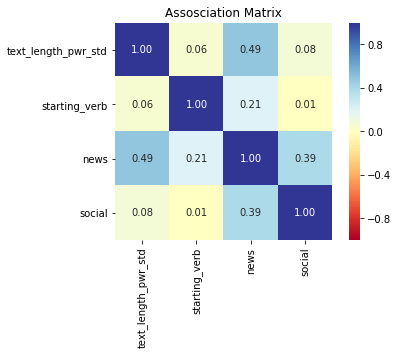

In [8]:
# Check if feature are multicolinear as logistic regression is sensitive to it
corr_matrix(
    X_eng_resampled, 
    nominal_columns=X_eng_resampled.columns[categorical_feature_msk],
    annot=True
)

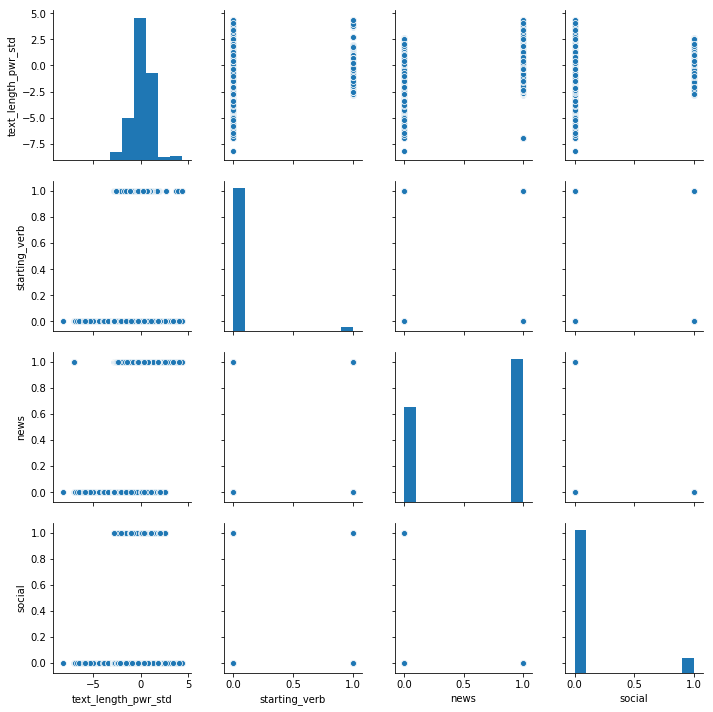

In [9]:
# Check distributions of input variables
sns.pairplot(X_eng_resampled);

In [10]:
# Fit multinomial logistic regression model
model = mn_logit_test(X_eng_resampled.drop(columns=['news']), 
                      y_resampled, 
                      method='newton')
print(model.summary())

C:\Users\Fredo\.conda\envs\DSND\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Optimization terminated successfully.
         Current function value: 3.496787
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:               703255
Model:                        MNLogit   Df Residuals:                   703119
Method:                           MLE   Df Model:                          102
Date:                Sat, 09 May 2020   Pseudo R-squ.:                 0.01647
Time:                        19:39:09   Log-Likelihood:            -2.4591e+06
converged:                       True   LL-Null:                   -2.5003e+06
                                        LLR p-value:                     0.000
           y=aid_related       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
x1                          -0.4193      0.010    -41.149      0.000      -0.43

### 2.2.3 Multi Nominal Logistic Regression Results
Even if the model is statistically significant it does not fit data well as Pseudo Rs-squ is very low (0.016). Statistical significance is given with high sample size. The engineered variables can be tested with the final classifier including a document-term matrix to see the real effect on model performance.

### 2.1. Corpus Dimensionality Reduction
`CustomCountVectorizer` class was created to handle corpus with a lot of numbers, hyperlinks, and slang words. It enables custom tagging for reducing the dimensionality of the document-term matrix. Other options are custom punctuation removal and lemmatization as well as plotting of most frequent words of corpus.

The incremental approach in analyzing corpus distribution below enabled to finetune count vectorizer settings. Number of
corpus terms reduced from 35121 to 29483. 

Standard `CountVectorizer` tokenizer is used as NLTK `word_tokenize` function almost doubled execution time and can significantly prolong tuning of the multi-label model.

In [11]:
class CustomCountVectorizer(CountVectorizer):
    '''CountVectorizer with custom word replacment, text tagging
    and token lemmatization. Attribute 'token_counts' holds dictionary
    of token keys and their counts in corpus. Uses method plot to plot
    distribution of tokens.
    
        Args:
            punct_regex: Regular expression to match punctuation, None by defaul
            
            tag_regex_dict: Dictionary with keys as custom tag names and 
                values as regular expression used to parse corpus for tagged 
                words. Matched strings will be replaced by key (tag)   
                
            replace_regex_dict: Dictionary with keys as custom words 
                and values as regular expression used to parse corpus for
                words to be replaced by custom words.
                
            lemmatizer: callable returning lemmatized token
                
            **kws: Keyword agruments passed to CountVectorizer init method
            
            NOTE: tag name need to fullmatch tokenizer pattern otherwise warnign
                  is raised. All tagas are converted in anlyzer to comply
                  '#' + tag.upper() (ex: cardinaldigit to #CARDNIALDIGIT)
                  
        Attributes:
            token_counts_: Dictionary mapping of tokens to their counts
            
            _ambiguous_tags: Set of ambiguous tag names in corpus. If not empty
                raises warning that tag is confouded with token having same name.
            
        Methods:
            plot(self [,topk, sortby, ascending]): plots distribution of tokens
    '''
    
    def __init__(self, punct_regex=None, tag_regex_dict=dict(), 
                 replace_regex_dict=dict(), lemmatizer=None,
                 input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
                 ngram_range=(1, 1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64):
        
        super().__init__(input, encoding, decode_error, strip_accents,
                         lowercase, preprocessor, tokenizer,stop_words, 
                         token_pattern, ngram_range, analyzer, max_df, 
                         min_df, max_features, vocabulary, binary, dtype)
        
        self.punct_regex = punct_regex
        self.tag_regex_dict = tag_regex_dict
        self.replace_regex_dict = replace_regex_dict
        self.lemmatizer = lemmatizer
        self._ambiguous_tags_ = set()
        
    def _postprocess(self, doc):
        '''Custom preprocessing of document/text'''
        
        # Check tag names for ambiguity in doc
        ambiguity_regex = r'|'.join([r'(\b' + tag_name + r'\b)' 
                                     for tag_name in self.tag_regex_dict])
        
        match = re.search(ambiguity_regex, doc, flags=re.IGNORECASE)
        
        if match:
            self._ambiguous_tags_ = self._ambiguous_tags_.union(set(match.groups()))
            
        # Normalize cases and unicode characters
        preprocess = super().build_preprocessor()
        doc = preprocess(doc)
        
        # Custom tagging
        if self.tag_regex_dict:
            for tag, regex in self.tag_regex_dict.items():
                doc = re.sub(regex, tag, doc, flags=re.IGNORECASE)
            
        # Replacement by custom words
        if self.replace_regex_dict:
            for word, replace_regex in self.replace_regex_dict.items():
                doc = re.sub(replace_regex, word, doc, flags=re.IGNORECASE)
                
        # Remove puncutation
        if self.punct_regex:
            doc = re.sub(self.punct_regex, ' ', doc, flags=re.IGNORECASE)
        
        return doc

    def build_preprocessor(self):
        '''Build custom preprocessor function'''

        return self._postprocess
    
    def _check_tags(self, tokenizer):
        '''Checks if tag name matches tokenizer pattern'''
        for tag in self.tag_regex_dict:
            tokenized_tag = tokenizer(tag)[0]
            
            assert tag == tokenized_tag, \
            'Can not build tokenizer! Tag {} does not ' \
            'match token pattern. Tokenize tag is {}.' \
            .format(tag, tokenized_tag)
    
    def _lemmatize(self, doc, tokenizer):
        '''Lemmatize document/text'''
        
        return [self.lemmatizer(token) for token in tokenizer(doc)]
        
            
    def build_tokenizer(self):
        '''Return a custom function that splits a string into 
        seuqence of tokens and lemmatize and tag them.
        '''
        if self.tokenizer is not None:
            tokenizer = self.tokenizer
        else:
            token_pattern = re.compile(self.token_pattern, 
                                       flags=re.IGNORECASE)
            tokenizer = token_pattern.findall
        
        if callable(self.lemmatizer):
            return partial(self._lemmatize, tokenizer=tokenizer)
        else:
            return tokenizer
    
    def _pos_tag(self, txt):
        '''return custom part of speach (POS) tag of the text'''
        
        pos_token = pos_tag([txt])
        token, tag = pos_token[0][0], pos_token[0][1]
        token = self.pos_tag_dict[tag] if tag in self.pos_tag_dict else token
        
        return token
    
    def _tag(self, doc, analyzer):
        '''Format tags to according pattern #TAGNAME'''
        
        return ['#' + token.upper() if token in self.tag_regex_dict else token
                for token in analyzer(doc)]
                    
        
    def build_analyzer(self):
        '''Return a custom collable that handles preprocessing,
        tokenization, n-grams and tags generation
        '''
        parent_analyzer = super().build_analyzer()
        
        # Checks if tag names have full match with tokenizer pattern
        self._check_tags(self.build_tokenizer())
        
        # Handle tagging
        if self.tag_regex_dict:
            return partial(self._tag, analyzer=parent_analyzer)
        else:
            return parent_analyzer
        
    def fit_transform(self, raw_documents, y=None):
        '''Extend fit tranform method by setting token_counts_ attribute
           and checking ambigious tag names.'''
        
        X = super().fit_transform(raw_documents, y)
        
        # Set token_counts_ attribute
        token_names = self.get_feature_names()
        token_counts = np.asarray(X.sum(axis=0)).squeeze()
        
        token_counts = dict(zip(token_names, token_counts))
        self.token_counts_ = token_counts
        
        # Check ambiguous tags
        self._ambiguous_tags_ -= {None}
        if self._ambiguous_tags_:
            warnings.warn('Ambiguous tags in corpus found: {}'
                          .format(self._ambiguous_tags_))
        
        return X
        
    def plot(self, topk=None, sortby=None, ascending=True, **kws):
        '''Plots bar chart of token counts.
        
        Args:
            topk: Integers, plots top k tokens, 20 by default
            sortby: String, whether to sort by 'token' or 'count'.
                None by default means keeping document-term matrix order
            ascending: Boolean, False means sort descanding. True by default.
            title: String, title of the chart None by Default
        
            **kws: Keyword arguments to pandas.DataFrame.plot function
        '''
        
        check_is_fitted(self, attributes=['token_counts_'],
                        msg='Token counts are not fitted')
        
        token_counts = pd.Series(self.token_counts_)
        
        # Handle sorting
        if sortby == 'token':
            token_counts.sort_index(inplace=True, ascending=ascending)
        elif sortby == 'count':
            token_counts.sort_values(inplace=True, ascending=ascending)
        
        # Handle title
        if topk:
            token_counts = token_counts[:topk]
            title = 'Distribution of top {} tokens'.format(topk)
        else:
            title = 'Tokens Distribution'
            
        if 'title' in locals():
            kws['title'] = title if 'title' not in kws else kws['title']
        
        # Plot bar chart
        token_counts.plot.bar(**kws)
        
        return None

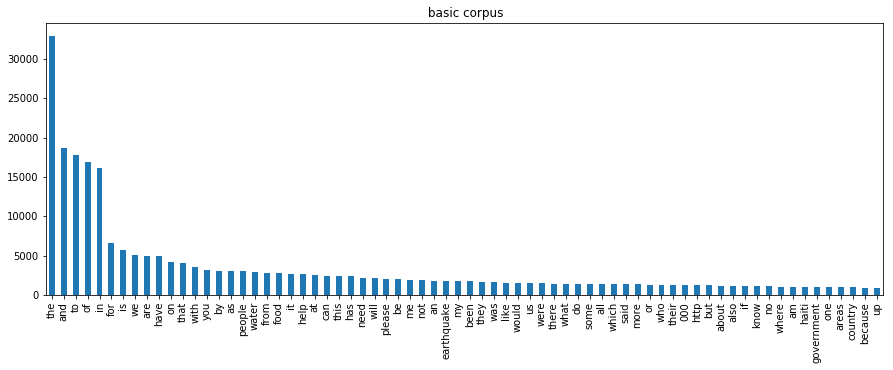

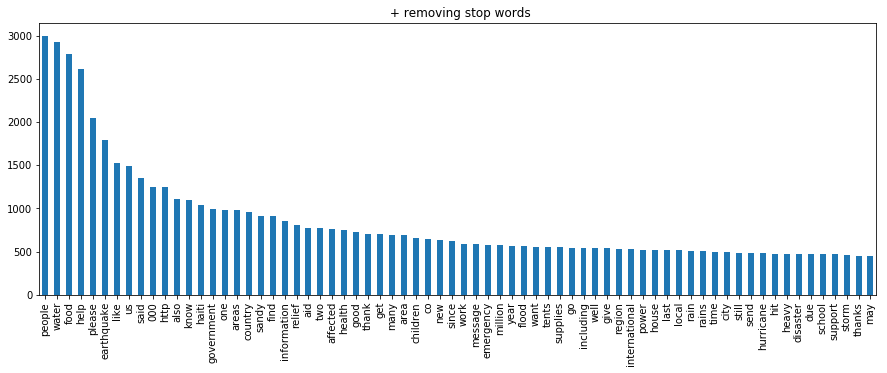

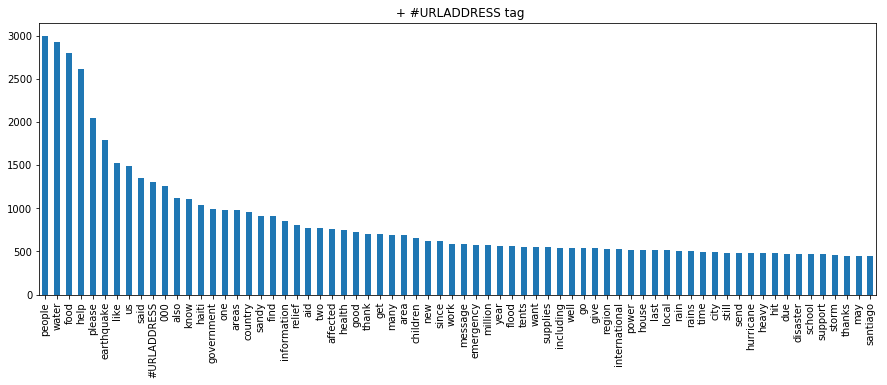

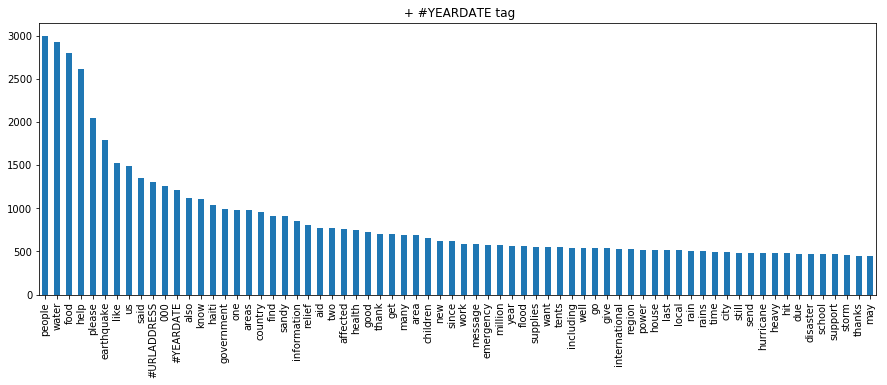

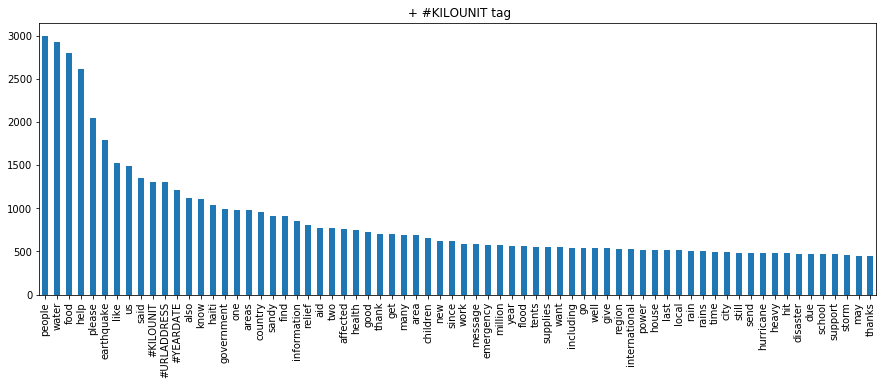

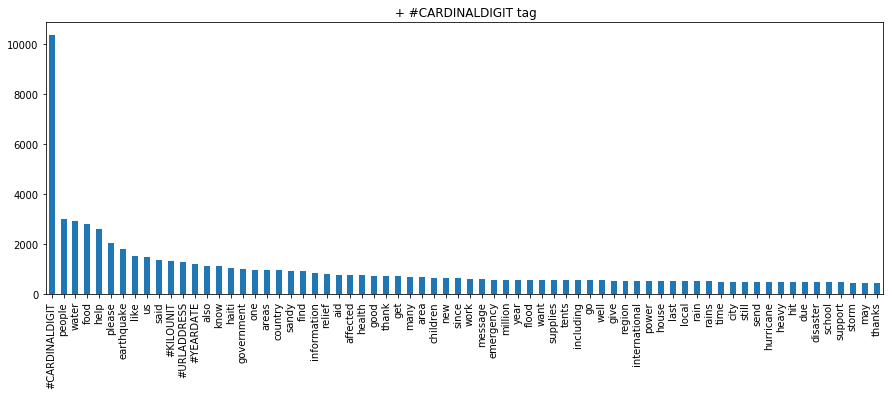

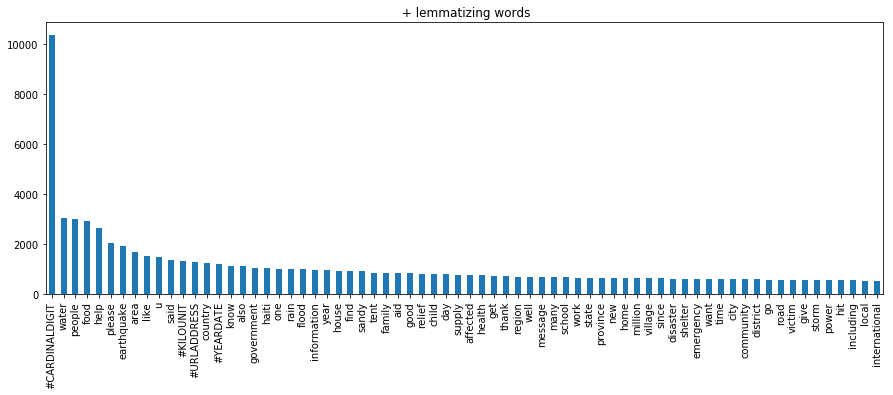

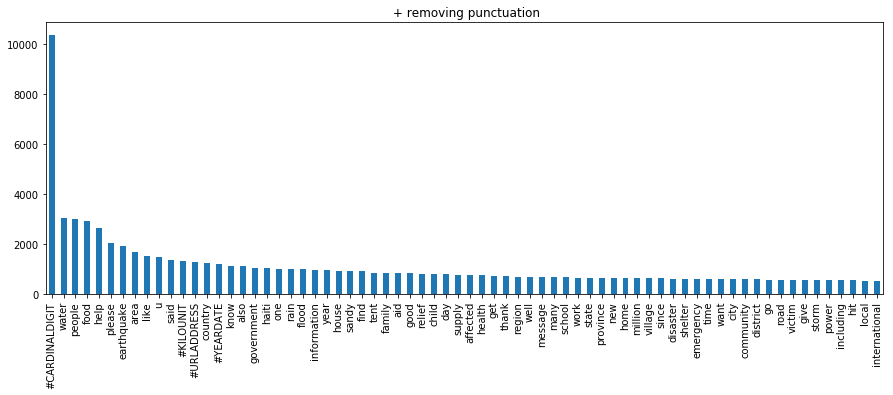

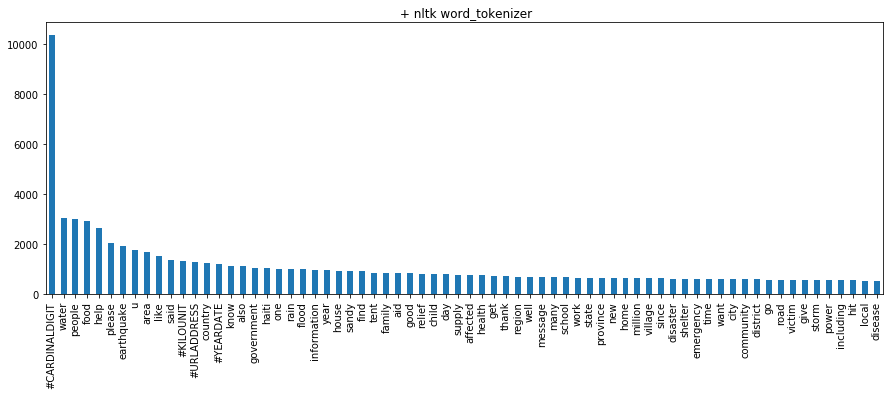

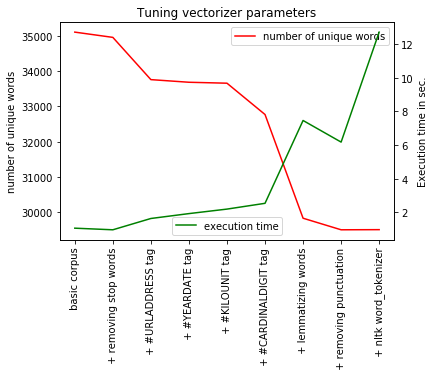

In [12]:
# Design settings for CustomCountVectorizer
# -----------------------------------------------------------

# Regext for removing  punctuation
punct_regex = r'[^a-zA-Z]'

# Regex expressions for custom tagging
tag_list = ['urladdress', 
            'yeardate', 
            'kilounit', 
            'cardinaldigit']

regex_list = [
    r'(?:(?:(?:URL:?)?http[s]?\s?:?\s?(?://)?(?:www.)?)|(?:www))' \
    r'(?:(?:(?:bit.ly|ow.ly|j.mp|tinyurl.com|tr.im|tl.gd'         \
    r'|goo.gl\s?fb|ur14.eu|su.pr|ff.im|goto.gg|uurl.in|url.ie'    \
    r'|digg.com|rep.ly|twitpic.com|nxy.in)\s?)|[a-zA-Z]|[0-9]'    \
    r'|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    r'(?:19[0-9]{2})|(?:20(?:(?:[0-1][0-9])|(?:20)))',
    r'[1-9](?:[0-9])*\s?,?\s?000',
    r'(?:\b[1-9][0-9]*(?:,[0-9]+)?(?:\.\s?[0-9]+)?)|(?:\btwo\b)'    
]

tag_regex_dict = dict(zip(tag_list, regex_list))

# Regex expressions for replacing slang words (replace 'u' with 'you')
slang_regex_dict = {'you': r'(?<!@)\bu\b(?!(?:\.\s?\w\.)+)(?!\s\w\s)(?!@)'}

# Update stopwords by CountVectorizer warning suggestion
stop_words = stopwords.words('english')
stop_words.extend(["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 
                  'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would', 'n'])

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer() 

# Design incremental approach to reduce corpus dimensionality
title_list = [
    ' basic corpus',
    ' + removing stop words',
    ' + #URLADDRESS tag',
    ' + #YEARDATE tag',
    ' + #KILOUNIT tag',
    ' + #CARDINALDIGIT tag',
    ' + lemmatizing words',
    ' + removing punctuation',
    ' + nltk word_tokenizer'
]

punct_regex_list = ([None] * 7 + [punct_regex] * 2)

tag_regex_dict_list = (
    [dict()] * 2
    + [{tag: tag_regex_dict[tag] for tag in tag_list[:i]} 
       for i in range(1, len(tag_list) + 1)]
    + [tag_regex_dict] * 3
)

slang_regex_dict_list = ([dict()] * 7 + [slang_regex_dict] * 2)
stop_words_list = ([None] + [stop_words] * 8)
lemmatizer_list = ([None] * 6 + [WordNetLemmatizer().lemmatize] * 3)
tokenizer_list = ([None] * 8 + [word_tokenize])

# Analyze corpus
num_unique_words_list = []
execution_time_list = []
for i in range(len(title_list)):
    
    # Construct vectorizer keyword arguments
    vec_kws = {
        'punct_regex': punct_regex_list[i],
        'tag_regex_dict': tag_regex_dict_list[i],
        'replace_regex_dict': slang_regex_dict_list[i],
        'lemmatizer': lemmatizer_list[i],
        'tokenizer': tokenizer_list[i],
        'stop_words': stop_words_list[i],
    }
    
    # Construct plot keyword arguments
    plot_kws = {
        'topk': 70,
        'sortby': 'count',
        'ascending': False,
        'figsize': (15, 5),
        'title': title_list[i]
    }
    
    # Plot corpus distribution
    start = time.time()
    
    vec = CustomCountVectorizer(**vec_kws).fit(X['message'])

    execution_time = time.time() - start
    
    vec.plot(**plot_kws)
    plt.show()
    
    execution_time_list.append(execution_time)
    num_unique_words_list.append(len(vec.vocabulary_))
    
# Plot dimensionality reduction with time execution
sns.lineplot(title_list, num_unique_words_list, color='red', sort=False)
plt.title('Tuning vectorizer parameters')
plt.ylabel('number of unique words')
plt.legend(['number of unique words'])
plt.xticks(rotation=90)
ax2 = plt.twinx()
ax2.set_ylabel('Execution time in sec.')
chart = sns.lineplot(title_list, execution_time_list, ax=ax2, color='green', sort=False)
plt.legend(['execution time'], loc='lower center');

## 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [13]:
random_state=1

def build_model():
    '''Builds machine learning pipeline.'''
    
    pipeline = Pipeline([
        
        # Handle preprocessing of text data
        ('preprocessor', ColumnTransformer([

            # Encode 'genre' variable using one hot encoding
            ('genre', OneHotEncoder(drop=[['news']]),
            ['genre']),

            # Fusion of document term metrix with text length
            ('text_union', FeatureUnion([

                # Exctract, transform and normalizes text length
                # to comply with normality reprequiste of linear models
                ('text_length', Pipeline([
                    ('extractor', TextLengthExtractor()),
                    ('transformer', PowerTransformer()),
                    ('scaler', StandardScaler())
                ])),
                
                ('start_verb', StartingVerbExtractor()),

                # Create document term matrix
                ('text_pipeline', Pipeline([

                    # Generate counts
                    ('vect', CustomCountVectorizer(
                        punct_regex=punct_regex,
                        tag_regex_dict=tag_regex_dict,
                        replace_regex_dict=slang_regex_dict,
                        lemmatizer=lemmatizer.lemmatize,
                        tokenizer=None,
                        stop_words=stop_words,
                        max_features=None)),

                    # Tranform counts to Tf-Idf
                    ('tfidf', TfidfTransformer())
                ]))

            # Apply text union only on message column
            ], n_jobs=1), 'message')

        # Drop remaining columns in dataframe
        ], remainder='drop', n_jobs=1)),
        
        # Multi-label classification
        ('classifier', OneVsRestClassifier(
            estimator=LinearSVC(dual=False, 
                                random_state=random_state),
            n_jobs=1
        ))
    ])
    
    return pipeline

## 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=random_state
)

test_pipeline = build_model()
test_pipeline.fit(X_train, Y_train);

## 6. Improve your model
Use a grid search to find better parameters. 

### 6.1 Model Selection
As text classification problems are computationally expensive I rather start with simple models __Linear SVC__ and __Naive Bayes__ over __Ensemblers__ which are lighter on memory usage and storage and enable me to deploy the model on Heroku within free account limitations. Both models have an advantage of coping with imbalanced datasets whether using `ComplementNB` or `LinearSVC` with `class_weight='blanced'`.

As __Naive Bayes__ belongs to probability models the use of __term frequency and inverse document frequency__ transformer and engineered features are not used in this case as it solely rely on term counts in the document.

In respect to the above considerations, the reference model is `DummyClassifier` who generates predictions uniformly at random.

In [15]:
screen_parameters= [
    # Linear SVP pipeline with tfidf and engineered features
    {'classifier': [OneVsRestClassifier(
        estimator=LinearSVC(class_weight='balanced',
                            dual=False,
                            random_state=random_state),
        n_jobs=1
    )]},
    
    # Probabilistic pipeline with count document-term matrix
    {'preprocessor__genre': ['drop'],
     'preprocessor__text_union__text_length': ['drop'],
     'preprocessor__text_union__start_verb': ['drop'],
     'preprocessor__text_union__text_pipeline__tfidf': ['passthrough'],
     'classifier': [MultiOutputClassifier(
         estimator=ComplementNB(),
         n_jobs=1
     )]},
    
    # Referenced pipeline
    {'preprocessor__text_union__text_pipeline__tfidf': [TfidfTransformer()],
     'classifier': [MultiOutputClassifier(
        estimator=DummyClassifier(strategy='uniform',
                                  random_state=random_state),
        n_jobs=1
    )]},    
    
]

screen_pipeline = build_model()

screen_cv = GridSearchCV(screen_pipeline, 
                         param_grid=screen_parameters,
                         scoring=['accuracy', 
                                  'precision_macro', 
                                  'recall_macro', 
                                  'f1_macro'],
                         cv=3, 
                         return_train_score=True,
                         refit='f1_macro',
                         verbose=0,
                         n_jobs=1)

screen_cv.fit(X_train, Y_train);

In [16]:
def get_result(grid_search_obj, param_list, metric_list, **sort_kws):
    '''Display selected metrics with grid search 
    parameters in dataframe with sort options'''

    result = pd.DataFrame(grid_search_obj.cv_results_)
    columns = (param_list + metric_list)
    
    if sort_kws:
        result = result.sort_values(**sort_kws)

    return result[columns]

# Display resuts
param_list = [
    'param_classifier'
]
metric_list = [
    'mean_train_accuracy', 
    'mean_test_accuracy', 
    'mean_train_precision_macro',
    'mean_test_precision_macro', 
    'mean_train_recall_macro',
    'mean_test_recall_macro', 
    'mean_train_f1_macro',
    'mean_test_f1_macro'
]
get_result(screen_cv, param_list, metric_list, by='rank_test_f1_macro')

,param_classifier,mean_train_accuracy,mean_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro
0,"OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.728424,0.217576,0.839421,0.425205,0.968185,0.454646,0.897957,0.434030
1,MultiOutputClassifier(estimator=ComplementNB(a...,0.243205,0.157734,0.344717,0.260260,0.558570,0.344103,0.420342,0.292930
2,MultiOutputClassifier(estimator=DummyClassifie...,0.117418,0.117204,0.089163,0.088271,0.494580,0.481981,0.121624,0.119879


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [17]:
def evaluate_model(estimator, X, Y, **kws):
    '''Prints classification report.'''
    Y_pred = estimator.predict(X)
    print(classification_report(Y, Y_pred, **kws))
    
evaluate_model(screen_cv.best_estimator_, X_train, Y_train, target_names=Y.columns)
evaluate_model(screen_cv.best_estimator_, X_test, Y_test, target_names=Y.columns)

                        precision    recall  f1-score   support

               related       0.99      0.93      0.96     16090
               request       0.80      0.98      0.88      3550
                 offer       0.85      1.00      0.92        93
           aid_related       0.91      0.95      0.93      8708
          medical_help       0.72      0.99      0.83      1649
      medical_products       0.74      1.00      0.85      1055
     search_and_rescue       0.73      1.00      0.85       589
              security       0.74      1.00      0.85       376
              military       0.86      1.00      0.93       707
           child_alone       0.00      0.00      0.00         0
                 water       0.84      1.00      0.92      1335
                  food       0.87      1.00      0.93      2338
               shelter       0.83      1.00      0.90      1863
              clothing       0.82      1.00      0.90       320
                 money       0.81      

## 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

The above pipeline has been already designed with feature union of document-term metrics, text length, and one-hot encoded genre variable. Engineered features have been proven significant, but their practical importance has not been tested in conjunction with the document-term matrix. This is done in the following section including bi-grams.

In [18]:
tune_parameters= {
    
    # Evaluate effect of genre variable
    'preprocessor__genre': 
    [OneHotEncoder(drop=[['news']]), 'drop'],
    
    # Evaluate effect of message length
    'preprocessor__text_union__text_length':
    [Pipeline([('extractor', TextLengthExtractor()),
               ('transformer', PowerTransformer()),
               ('scaler', StandardScaler())]), 
     'drop'],
    
    # Evaluate effect of sentence starting with verb
    'preprocessor__text_union__start_verb':
    [StartingVerbExtractor(), 'drop'],
    
    # Evaluate effect of uni-grams vs. bi-grams
    'preprocessor__text_union__text_pipeline__vect__ngram_range':
    [(1, 1), (1, 2)],
    
    # Linear Support Vector Machines Model with weight balancing
    'classifier': [OneVsRestClassifier(
            estimator=LinearSVC(class_weight='balanced',
                                dual=False,
                                random_state=random_state),
            n_jobs=1
        )]
}

tune_pipeline = build_model()

tune_cv = GridSearchCV(tune_pipeline, 
                       param_grid=tune_parameters,
                       scoring=['accuracy', 
                                'precision_macro', 
                                'recall_macro', 
                                'f1_macro'],
                       cv=3, 
                       return_train_score=True,
                       refit='f1_macro',
                       verbose=0,
                       n_jobs=1)
                       
tune_cv.fit(X_train, Y_train);

In [19]:
param_list=['param_' + key for key in tune_cv.param_grid]
get_result(tune_cv, param_list, metric_list, by='rank_test_f1_macro')

,param_preprocessor__genre,param_preprocessor__text_union__text_length,param_preprocessor__text_union__start_verb,param_preprocessor__text_union__text_pipeline__vect__ngram_range,param_classifier,mean_train_accuracy,mean_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro
7,"OneHotEncoder(categories='auto', drop=[['news'...",drop,drop,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.960948,0.270122,0.951199,0.498747,0.971836,0.443929,0.961364,0.457507
5,"OneHotEncoder(categories='auto', drop=[['news'...","(TextLengthExtractor(), PowerTransformer(copy=...",drop,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.962068,0.279707,0.951778,0.503490,0.971835,0.437272,0.961661,0.457316
3,"OneHotEncoder(categories='auto', drop=[['news'...",drop,StartingVerbExtractor(tokenizer=<function word...,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.961067,0.270170,0.951264,0.495818,0.971834,0.443733,0.961397,0.457293
15,drop,drop,drop,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.960757,0.267929,0.950875,0.497942,0.971872,0.443873,0.961216,0.457071
1,"OneHotEncoder(categories='auto', drop=[['news'...","(TextLengthExtractor(), PowerTransformer(copy=...",StartingVerbExtractor(tokenizer=<function word...,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.962283,0.279754,0.951805,0.503245,0.971837,0.437004,0.961676,0.457006
11,drop,drop,StartingVerbExtractor(tokenizer=<function word...,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.960566,0.268072,0.950862,0.495194,0.971870,0.443806,0.961208,0.456874
13,drop,"(TextLengthExtractor(), PowerTransformer(copy=...",drop,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.961568,0.278467,0.951378,0.501995,0.971854,0.437670,0.961465,0.456739
9,drop,"(TextLengthExtractor(), PowerTransformer(copy=...",StartingVerbExtractor(tokenizer=<function word...,"(1, 2)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.961615,0.277990,0.951392,0.502243,0.971856,0.437549,0.961474,0.456693
0,"OneHotEncoder(categories='auto', drop=[['news'...","(TextLengthExtractor(), PowerTransformer(copy=...",StartingVerbExtractor(tokenizer=<function word...,"(1, 1)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.728424,0.217576,0.839421,0.425205,0.968185,0.454646,0.897957,0.434030
4,"OneHotEncoder(categories='auto', drop=[['news'...","(TextLengthExtractor(), PowerTransformer(copy=...",drop,"(1, 1)","OneVsRestClassifier(estimator=LinearSVC(C=1.0,...",0.728710,0.217671,0.840006,0.422648,0.968183,0.453935,0.898280,0.433025


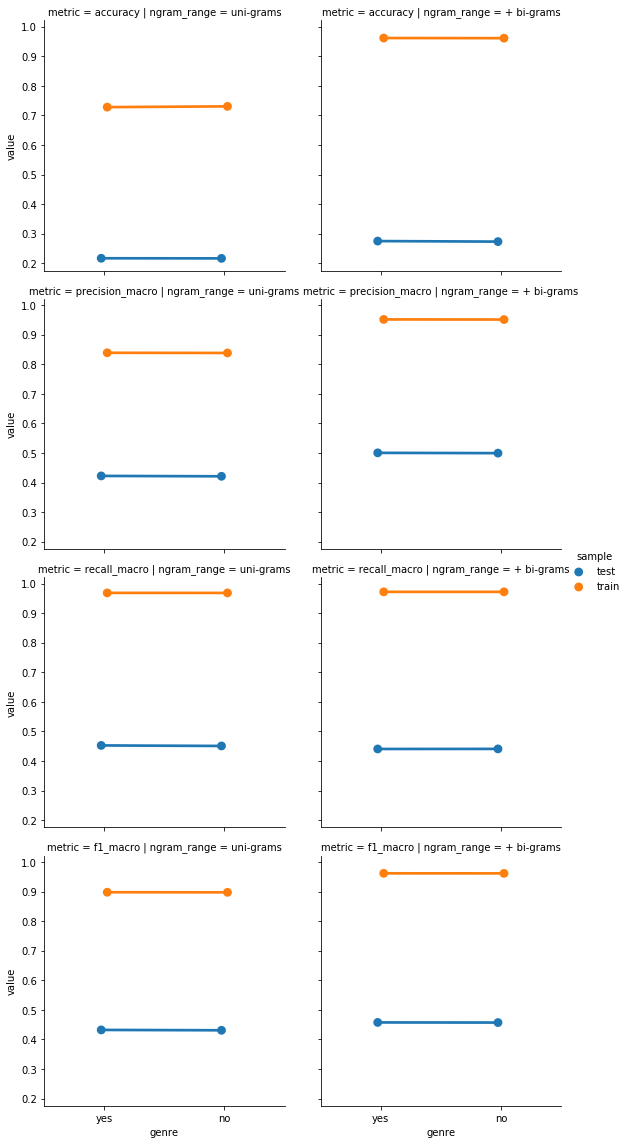

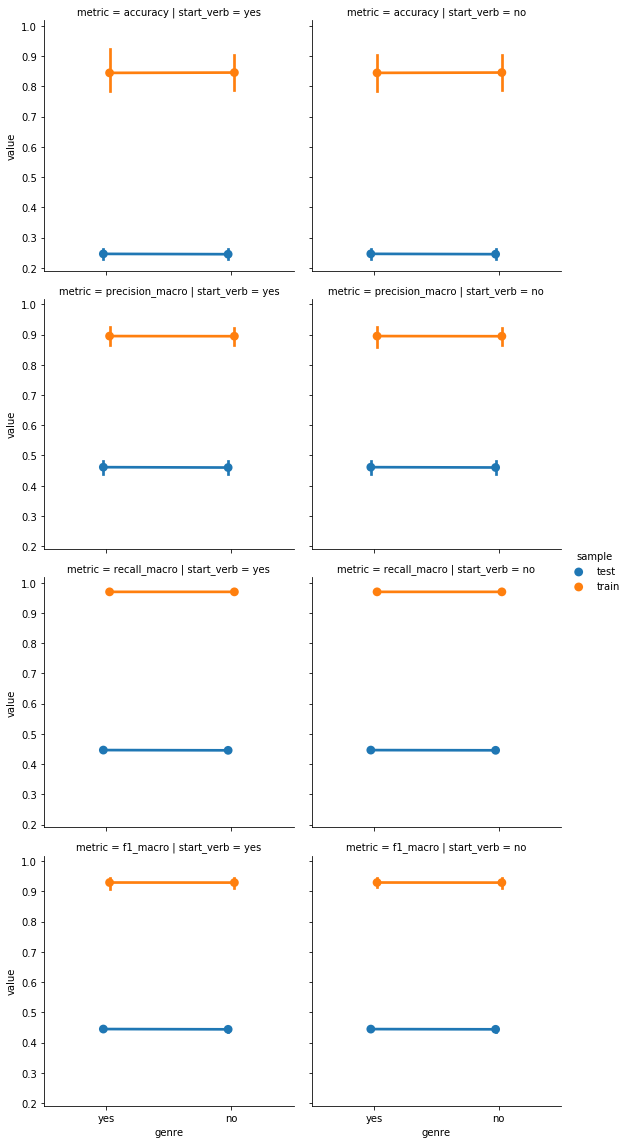

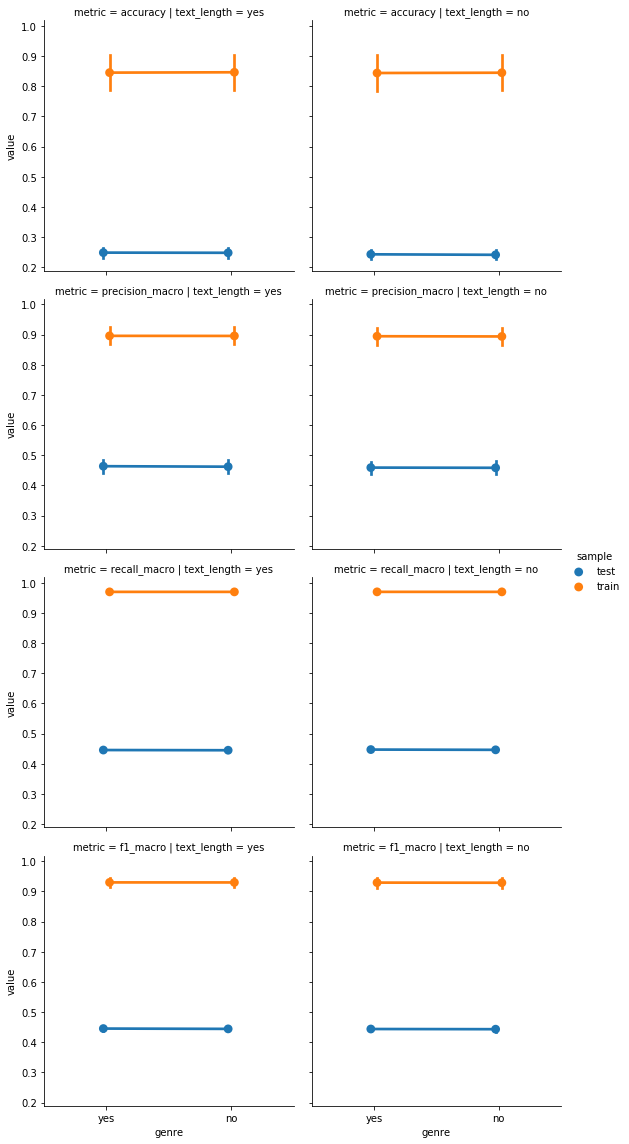

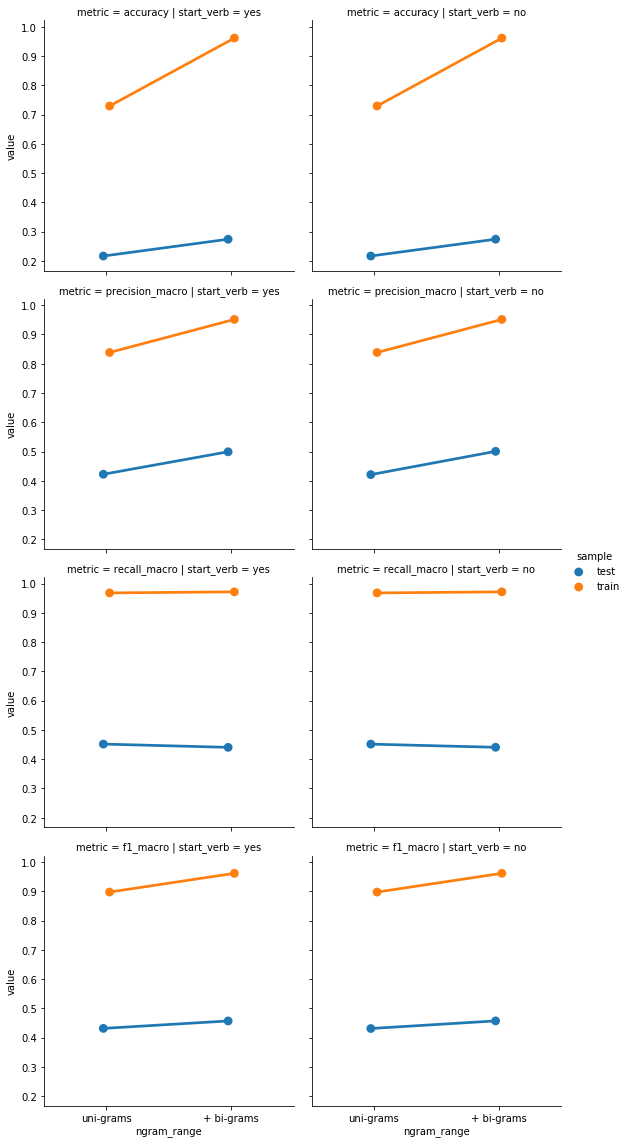

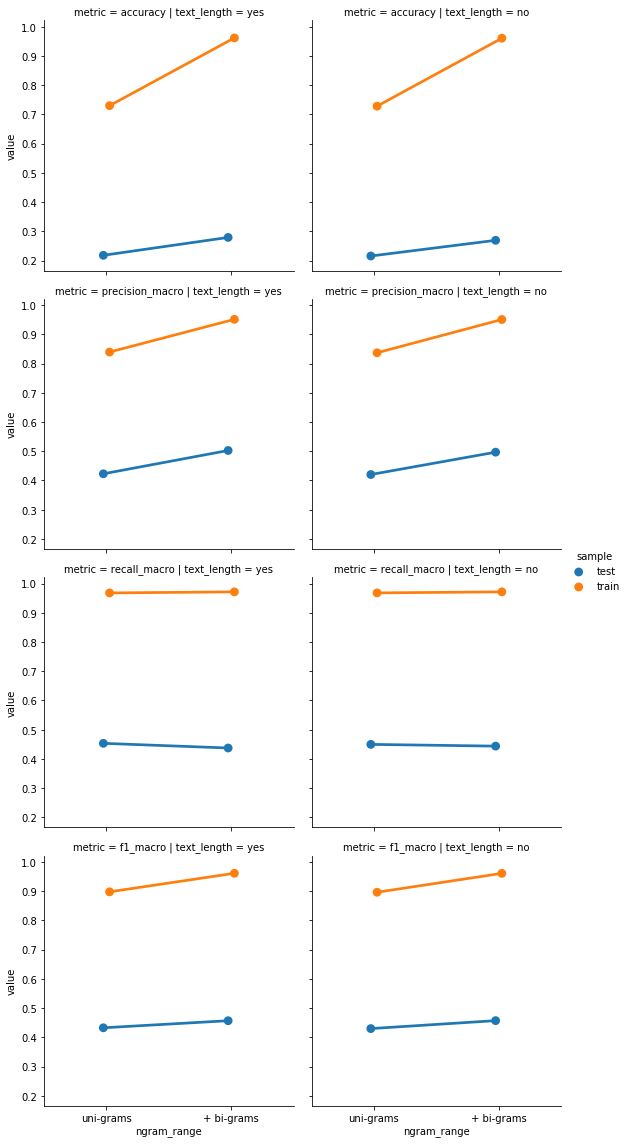

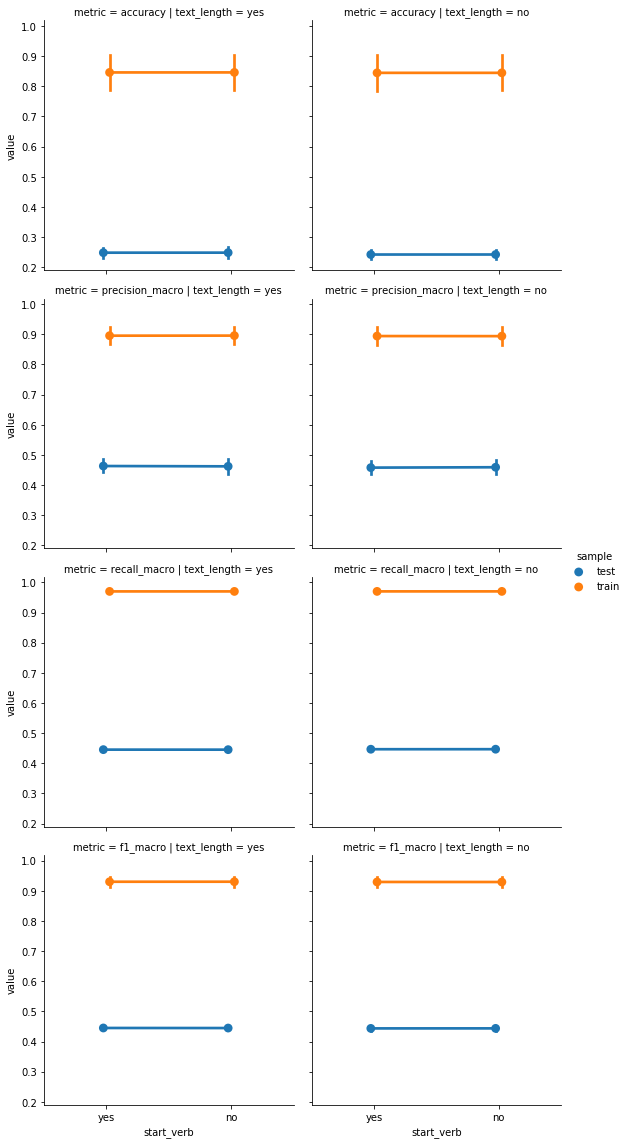

In [20]:
def plot_cv_results(grid_search_cv, **kws):
    '''Print pointplot of full grid search results'''
    
    assert isinstance(grid_search_cv.param_grid, dict), \
    'param_grid need to be dictionary (full grid)'
    
    df = stack_cv_results(grid_search_cv, **kws)
    
    param_list = (
        df.columns
        .difference(['sample', 'metric', 'value'])
        .to_list()
    )
    
    multi_level_param_list = [param for param in param_list
                              if len(df[param].unique()) > 1]
    
    plot_kws = {
        'dodge': True,
        'kind': 'point',
        'height': 4,
        'aspect': 1,
    }
    
    if len(multi_level_param_list) == 0:
        raise Exception('At least one parameter need to have ' 
                        + 'at least 2 levels to print results')

    elif len(multi_level_param_list) == 1:
        sns.catplot(x=multi_level_param_list[0],
                    y='value',
                    hue='sample', 
                    col='metric',
                    data=df, 
                    col_wrap=2,
                    **plot_kws);
        
    elif len(multi_level_param_list) >= 2:
        for param_a, param_b in combinations(
            multi_level_param_list, 2
        ):
            sns.catplot(x=param_a,
                        y='value',
                        hue='sample', 
                        col=param_b,
                        row='metric',
                        data=df, 
                        **plot_kws);

    else:
        NotImplemented

def stack_cv_results(grid_search_cv, alias_param_grid={}):
    '''Stacks cross validation results.
    
    Args:
        grid_search_cv: Fitted GridSearchCV object.
        alias_param_gird: The param grid dictionary to replace 
            hyper-parameters levels' names. Need to have same
            keys as GridSearchCV.param_grid. None by default.
    
    Returns:
        stacked_df: Dataframe with hyper-parameters and stacked
            cross validation metrics.
    
    Note: Only metrics matching r'^split\d+_.+' are included,
        means time metrics are exluded. Hyper-parameters names 
        are adjusted, pipeline portion is cut-off for readability.
    '''
    
    assert check_is_fitted, \
    'GridSearchCV object need to be fitted.'
    
    param_grid = grid_search_cv.param_grid
    
    if alias_param_grid:
        assert alias_param_grid.keys() == param_grid.keys(), \
        'Keys of alias_param_grid and param_grid need to match.'
        
        for alias_key, key in zip(alias_param_grid, param_grid):
            assert (len(alias_param_grid[alias_key]) 
                    == len(param_grid[key])), \
            'Number of levels of {} and {} need to match.' \
            .format(alias_key, key)
    
    df = pd.DataFrame(grid_search_cv.cv_results_)
    
    param_msk = df.columns.str.contains(r'^param_.+', regex=True)   
    metric_msk = df.columns.str.contains(r'^split\d+_.+', regex=True)
    
    stacked_df = pd.melt(df, 
                         id_vars=df.columns[param_msk],
                         value_vars=df.columns[metric_msk],
                         var_name='metric',
                         value_name='value')
    
    stacked_df['sample'] = (
        stacked_df['metric']
        .apply(lambda metric: 
               'test' if 'test' in metric else 
               'train' if 'train' in metric else np.nan)
    )
    
    def replace(item, level_list, alis_level_list):
        try:
            item = alis_level_list[level_list.index(item)]
        except ValueError:
            pass
        
        return item
    
    if alias_param_grid:
        for param in param_grid:
            stacked_df['param_' + param] = (
                stacked_df['param_' + param]
                .apply(replace, args=(param_grid[param],
                                      alias_param_grid[param])
                )
            )
            
    stacked_df.columns = [column
                          .replace('param_', '', 1)
                          .split('__')[-1]
                          for column in stacked_df.columns]
    
    stacked_df['metric'] = (
        stacked_df['metric']
        .apply(lambda metric: 
               '_'.join(metric.split('_')[2:]))
    )
                                 
    return stacked_df

alias_param_grid = dict(zip(
    tune_cv.param_grid.keys(),
    [['yes', 'no'], 
     ['yes', 'no'], 
     ['yes', 'no'],
     ['uni-grams', '+ bi-grams'],
     ['LinearSVC + weights balancing']]
))

plot_cv_results(tune_cv, alias_param_grid=alias_param_grid)

In [21]:
evaluate_model(tune_cv.best_estimator_, X_train, Y_train, target_names=Y.columns)
evaluate_model(tune_cv.best_estimator_, X_test, Y_test, target_names=Y.columns)

                        precision    recall  f1-score   support

               related       1.00      0.99      0.99     16090
               request       0.96      1.00      0.98      3550
                 offer       0.97      1.00      0.98        93
           aid_related       0.99      1.00      0.99      8708
          medical_help       0.96      1.00      0.98      1649
      medical_products       0.96      1.00      0.98      1055
     search_and_rescue       0.97      1.00      0.98       589
              security       0.97      1.00      0.99       376
              military       0.96      1.00      0.98       707
           child_alone       0.00      0.00      0.00         0
                 water       0.94      1.00      0.97      1335
                  food       0.96      1.00      0.98      2338
               shelter       0.97      1.00      0.98      1863
              clothing       0.95      1.00      0.97       320
                 money       0.97      

### 8.1 


Looking to `mean_test_f1_macro` score it is evident that bi-grams are having the highest effect on model performance. `genre` is having a small positive impact on performance while bi-grams are considered. `text_legth` is having a small positive impact on performance while uni-grams are considered.

On the other hand, the model is highly overfitting which is mainly due to the number of increased variables using bi-grams. This can be remedied by:
 - an increasing number of training samples
 - reduce the number of features
 - decrease penalty parameter C
 
 The last two options will be tried in the last tuning step using both bi-grams and uni-grams. No engineered variables will be included as they have negligable impact on model performance.

In [22]:
parameters= {
    
    # Drop engineered features
    'preprocessor__genre': ['drop'],
    'preprocessor__text_union__text_length': ['drop'],
    'preprocessor__text_union__start_verb': ['drop'],
    
    # Keep uni-grams and bi-grams
    'preprocessor__text_union__text_pipeline__vect__ngram_range': 
    [(1, 1), (1, 2)],
    
    # Implement Multi-label model with feature selection
    'classifier': [OneVsRestClassifier(
            estimator=Pipeline([
                
                        # Feature selection based on l1 regularization
                        ('feature_selector', SelectFromModel(
                            LinearSVC(penalty='l1',
                                      dual=False,
                                      tol=1e-3,
                                      random_state=random_state)
                        )),
                
                        # Support Vector Machine model with weigth balancing
                        ('svm', LinearSVC(
                            class_weight='balanced',
                            dual=False, 
                            random_state=random_state
                        )),
            ]), n_jobs=1
        )],
    
    # Tune penalty parameter
    'classifier__estimator__svm__C': 
    [0.01, 0.1, 1]
}


pipeline = build_model()

cv = GridSearchCV(pipeline, 
                  param_grid=parameters,
                  scoring=['accuracy', 
                           'precision_macro', 
                           'recall_macro', 
                           'f1_macro'],
                  cv=3, 
                  return_train_score=True,
                  refit='f1_macro',
                  verbose=0,
                  n_jobs=1)
                       
cv.fit(X_train, Y_train);

In [23]:
param_list=[
    'param_preprocessor__text_union__text_pipeline__vect__ngram_range',
    'param_classifier__estimator__svm__C',
]
get_result(cv, param_list, metric_list, by='rank_test_f1_macro')

,param_preprocessor__text_union__text_pipeline__vect__ngram_range,param_classifier__estimator__svm__C,mean_train_accuracy,mean_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro
2,"(1, 1)",0.1,0.276368,0.174757,0.491980,0.355243,0.916300,0.586599,0.613815,0.426427
4,"(1, 1)",1,0.446023,0.170036,0.610402,0.362803,0.960401,0.526983,0.735425,0.423425
0,"(1, 1)",0.01,0.199790,0.160452,0.406442,0.338327,0.791906,0.599866,0.500105,0.407711
3,"(1, 2)",0.1,0.240988,0.116537,0.448244,0.289324,0.836128,0.662211,0.549960,0.373825
1,"(1, 2)",0.01,0.189538,0.114439,0.394944,0.283440,0.726857,0.648253,0.477348,0.362911
5,"(1, 2)",1,0.293987,0.101755,0.479497,0.276714,0.913928,0.644668,0.593808,0.361752


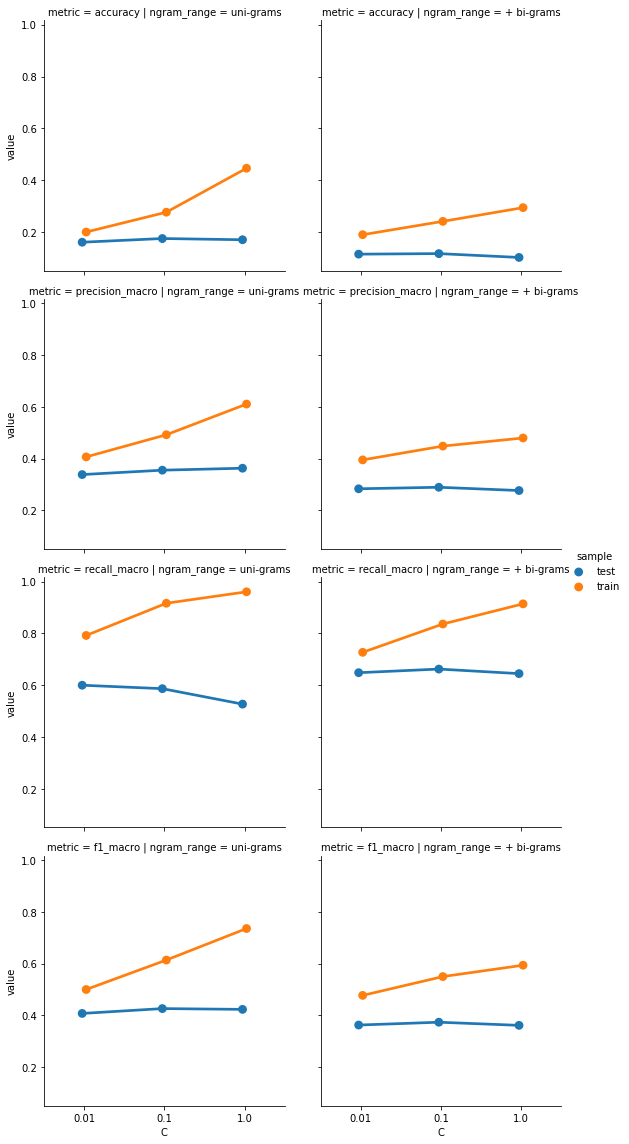

In [24]:
alias_param_grid = dict(zip(
    cv.param_grid.keys(),
    [['no'],
     ['no'],
     ['no'],
     ['uni-grams', '+ bi-grams'], 
     ['LinearSVC + weights balancing'],
     [0.01, 0.1, 1]]
))

plot_cv_results(cv, alias_param_grid=alias_param_grid)

In [25]:
evaluate_model(cv.best_estimator_, X_train, Y_train, target_names=Y.columns)
evaluate_model(cv.best_estimator_, X_test, Y_test, target_names=Y.columns)

                        precision    recall  f1-score   support

               related       0.96      0.83      0.89     16090
               request       0.66      0.84      0.74      3550
                 offer       0.17      0.99      0.29        93
           aid_related       0.81      0.80      0.80      8708
          medical_help       0.50      0.89      0.64      1649
      medical_products       0.44      0.94      0.60      1055
     search_and_rescue       0.32      0.98      0.49       589
              security       0.27      0.99      0.42       376
              military       0.52      0.99      0.68       707
           child_alone       0.00      0.00      0.00         0
                 water       0.62      0.94      0.75      1335
                  food       0.76      0.93      0.83      2338
               shelter       0.63      0.94      0.76      1863
              clothing       0.49      1.00      0.66       320
                 money       0.38      

### 8.2 Reduce Model Overfitting 
Using feature selection, tuning of penalty parameter C, and testing uni-grams and bi-grams have succeeded in reducing model overfitting from 50% to 17% while model performance reduced slightly from 46% to 42%.

### 9. Export your model as a pickle file

In [26]:
def save_model(model, model_filepath):
    '''Saves the model as a pickle file'''
    
    with open(model_filepath, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

save_model(cv, 'model.pickle')

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.